In [5]:
# This Structure of this python forecasting mdoel by LightGBM
# both tasks uses Light Gradient Boost Model LightGBM
# Content:
#1. Liberaries & Functions:
#   1.1 encode_categorical_features: to encode categorcial features: Division Name and so on
#   1.2 preprocess_text_features: using TF-IDF technique to vectorize text data: Title and Review Title
#   1.3 prepare_features_and_target: put together the processed features to fit in the model
#   1.4 train_and_save_lightgbm: does the grid search, fits the model and saves the best model
#   1.5 evaluate_model: evaluate the fit model's accuracy, print the resuts and visualize Confusion Matrix
#   1.6 predict_future: loads the saved model in task 1 or 2 and make prediction for the new record(s)

#2. Main:
#   2.1 Task 1: fits the prediction model, saves the best model and print the accuracy check on test dataset
#   2.2 Task 2: fits the prediction model, saves the best model and print the accuracy check on test dataset
#   2.3 Prediction for new records based on task 1 or 2

In [14]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import joblib

####### 1 - encoding Categorical Features ###############
def encode_categorical_features(train_df, test_df, categorical_cols):

    label_encoders = {}  # Store label encoders for future use

    for col in categorical_cols:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col].astype(str))

        # Handle unseen categories in the test set by assigning -1
        test_df[col] = test_df[col].astype(str).map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

        label_encoders[col] = le  # Store the trained encoder

    return train_df, test_df, label_encoders

######## 2. Preprocessing text features ####################
#########################################################################################################################
def preprocess_text_features(train_df, test_df, max_tfidf_features=5000):

    # Handle missing values in text columns
    imputer = SimpleImputer(strategy='most_frequent')
    train_df["Title"] = train_df["Title"].fillna("")
    train_df["Review Text"] = train_df["Review Text"].fillna("")
    test_df["Title"]=test_df["Title"].fillna("")
    test_df["Review Text"]= test_df["Review Text"].fillna("")



    # Convert text data into TF-IDF features
    tfidf_vectorizer = TfidfVectorizer(max_features=max_tfidf_features, stop_words='english')
    train_tfidf = tfidf_vectorizer.fit_transform(train_df["Review Text"] + " " + train_df["Title"])
    test_tfidf = tfidf_vectorizer.transform(test_df["Review Text"] + " " + test_df["Title"])

    return train_df, test_df, train_tfidf, test_tfidf, tfidf_vectorizer

### 3. Preparing features and target for the related task
######################################################################################################

def prepare_features_and_target(train_df, test_df, train_tfidf, test_tfidf, target_col, exclude_columns):
        
    # Default columns to exclude
    default_exclude = ["Review Text", "Title", target_col]
    
    # If exclude_columns is provided, extend the default exclusion list
    if exclude_columns:
        default_exclude.extend(exclude_columns)

    # Define structured features, excluding specified columns
    structured_features = [col for col in train_df.columns if col not in default_exclude]

    # Combine TF-IDF text features with structured features
    X_train = hstack((train_tfidf, train_df[structured_features]))
    y_train = train_df[target_col]

    X_test = hstack((test_tfidf, test_df[structured_features]))
    y_test = test_df[target_col]

    return X_train, y_train, X_test, y_test


### 4. run the grid search and fit the model: LightGBM  #############
#######################################################################################
def train_and_save_lightgbm(X_train, y_train, X_test, param_grid, model_filename):


    # Convert sparse matrices to DataFrame with feature names
    feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
    X_train_df = pd.DataFrame(X_train.toarray(), columns=feature_names)
    X_test_df = pd.DataFrame(X_test.toarray(), columns=feature_names)

    # Define the LightGBM classifier
    lgb_clf = lgb.LGBMClassifier(random_state=42, class_weight='balanced')

    # Perform Grid Search with Cross-Validation
    grid_search = GridSearchCV(lgb_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_df, y_train)

    # Print best model parameters
    print("Best Model Parameters:", grid_search.best_params_)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Save the trained LightGBM model
    joblib.dump(best_model, model_filename)
    print(f"Model saved successfully as {model_filename}")

    return best_model, grid_search, X_test_df


### 5. Predictin evaluation #############
############################################################
def evaluate_model(best_model, X_test, y_test, class_labels):

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_f1 = f1_score(y_test, y_pred, average='weighted')

    # Generate classification report
    class_report = classification_report(y_test, y_pred)

    print("Classification Report:\n")
    print(class_report)

    if y_test.name == 'Rating':
        print(f"Final Accuracy: {accuracy:.2f}")
    else:
        print(f"Final Weighted F1-score: {accuracy_f1:.2f}")

    # Visualization - Confusion Matrix
    plt.figure(figsize=(6, 5))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.title("Confusion Matrix for LightGBM Model")
    plt.show()

    return accuracy, class_report



### 6. Predict future data #################
################## prediction on new data ###################################################
def predict_future(data, task, label_encoders, tfidf_vectorizer):
   
    # Select the appropriate model based on the task
    model_filename = "lightgbm_task1_model.pkl" if task == 1 else "lightgbm_task2_model.pkl"
    target_col = "Recommended IND" if task == 1 else "Rating"

    # Load the trained LightGBM model
    loaded_model = joblib.load(model_filename)

    # Drop unnecessary columns if present
    if "Clothing ID" in data.columns:
        data.drop(columns=["Clothing ID"], inplace=True)

    # Handle missing values
    data["Title"] = data["Title"].fillna("")
    data["Review Text"] = data["Review Text"].fillna("")

    # Encode categorical features using pre-trained label encoders
    categorical_cols = ["Division Name", "Department Name", "Class Name"]
    for col in categorical_cols:
        if col in data.columns:
            data[col] = data[col].astype(str).map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)

    # Tokenizing the textual features using TF-IDF
    data_tfidf = tfidf_vectorizer.transform(data["Review Text"] + " " + data["Title"])

    # Define structured features (excluding text columns and target variable)
    structured_features = [col for col in data.columns if col not in ["Review Text", "Title", target_col]]

    # Combine TF-IDF text features with structured features
    data_features = hstack((data_tfidf, data[structured_features]))

    # Convert to DataFrame with feature names to prevent warnings
    feature_names = [f"feature_{i}" for i in range(data_features.shape[1])]
    X_data_prediction = pd.DataFrame(data_features.toarray(), columns=feature_names)

    # Perform the prediction
    predictions = loaded_model.predict(X_data_prediction)

    return predictions

[LightGBM] [Info] Number of positive: 15467, number of negative: 3321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103705
[LightGBM] [Info] Number of data points in the train set: 18788, number of used features: 2034
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Best Model Parameters: {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 50}
Model saved successfully as lightgbm_task1_model.pkl
Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       851
           1       0.94      0.94      0.94      3847

    accuracy                           0.90      4698
   macro avg       0.83      0.83      0.83      4698
weighted avg       0.90      0.90      0.90      4698

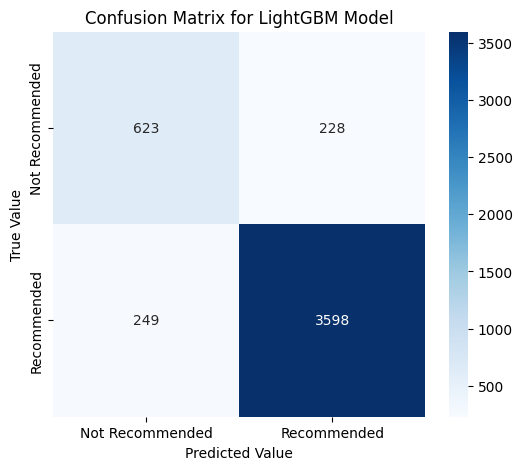

In [15]:
############### Task 1 ###########################################

# Load datasets
train_df = pd.read_csv("C:/GitHub/Machine-Learning/INF1279H/train_data.csv")
test_df = pd.read_csv("C:/GitHub/Machine-Learning/INF1279H/test_data.csv")

# Define categorical columns
categorical_cols = ["Division Name", "Department Name", "Class Name"]

# Encode categorical features
train_df, test_df, label_encoders = encode_categorical_features(train_df, test_df, categorical_cols)

# Preprocess text features and transform using TF-IDF
train_df, test_df, train_tfidf, test_tfidf, tfidf_vectorizer = preprocess_text_features(train_df, test_df)

# Train LightGBM Model with Hyperparameter Tuning
param_grid = {
    'num_leaves': [50],            #31, 50, 100
    'learning_rate': [0.05],     #0.01, 0.05, 0.1
    'n_estimators': [500],        #100, 200, 500
    'max_depth': [-1]               #-1, 10, 20
}



# Prepare features and target variables
X_train, y_train, X_test, y_test = prepare_features_and_target(train_df, test_df, train_tfidf, test_tfidf,target_col="Recommended IND", exclude_columns=["Clothing ID","Rating"])

# Train model and save it
best_lgb_model, grid_search_results, X_test_df = train_and_save_lightgbm(X_train, y_train, X_test, param_grid, "lightgbm_task1_model.pkl")

# Evaluate the best LightGBM model
accuracy, class_report = evaluate_model(best_lgb_model, X_test_df, y_test,["Not Recommended", "Recommended"])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103707
[LightGBM] [Info] Number of data points in the train set: 18788, number of used features: 2035
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Best Model Parameters: {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 100}
Model saved successfully as lightgbm_task2_model.pkl
Classification Report:

              precision    recall  f1-score   support

           1       0.34      0.29      0.31       153
           2       0.38      0.37      0.38       317
           3       0.47      0.37      0.41       620
           4       0.45      0.41      

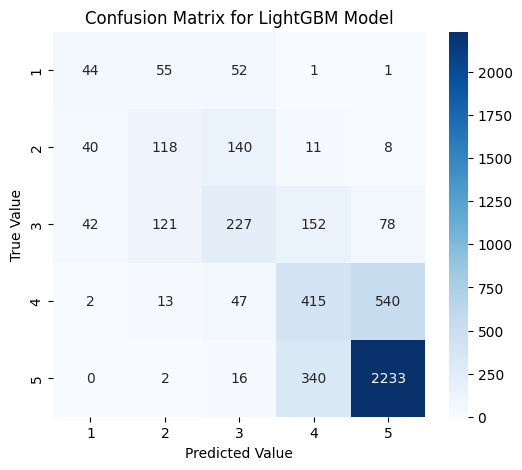

In [ ]:
############## Task 2 ###############################
# Load datasets
train_df = pd.read_csv("C:/GitHub/Machine-Learning/INF1279H/train_data.csv")
test_df = pd.read_csv("C:/GitHub/Machine-Learning/INF1279H/test_data.csv")

# Define categorical columns
categorical_cols = ["Division Name", "Department Name", "Class Name"]

# Encode categorical features
train_df, test_df, label_encoders = encode_categorical_features(train_df, test_df, categorical_cols)

# Preprocess text features and transform using TF-IDF
train_df, test_df, train_tfidf, test_tfidf, tfidf_vectorizer = preprocess_text_features(train_df, test_df)

# Train LightGBM Model with Hyperparameter Tuning
# The paramters are set to the best combination to reduce the process time. However, 
param_grid = {
    'num_leaves': [100],            #31, 50, 100
    'learning_rate': [0.05],     #0.01, 0.05, 0.1
    'n_estimators': [500],        #100, 200, 500
    'max_depth': [-1]               #-1, 10, 20
}

# Prepare features and target variables
X_train, y_train, X_test, y_test = prepare_features_and_target(train_df, test_df, train_tfidf, test_tfidf, target_col="Rating", exclude_columns=["Clothing ID"])

# Train model and save it
best_lgb_model, grid_search_results, X_test_df = train_and_save_lightgbm(X_train, y_train, X_test, param_grid, "lightgbm_task2_model.pkl")

# Evaluate the best LightGBM model
accuracy, class_report = evaluate_model(best_lgb_model, X_test_df, y_test, ["1", "2", "3", "4", "5"])

In [ ]:
########### set the task parameter to 1 or 2 and give correct address to load the new_dataset address to predict new records based on task 1 or 2

task = 1  # Set to 1 for "Recommended IND" prediction, 2 for "Rating" prediction
new_data = pd.read_csv("new_data.csv")  # Load new data for prediction

# Perform prediction
predictions = predict_future(new_data, task, label_encoders, tfidf_vectorizer)

print(predictions)